# Overlay Raster and Vector Spatial Data in A Matplotlib Plot Using Extents in Python

You often want to create a map that includes a raster layer (for example a satelite image) with vector data such as political boundaries or study area boundaries overlayed on top of that raster layer.

In order to plot the raster and vector data together in the same plot, you need to identify the spatial extent of the raster data file so that matplotlib can correctly place the raster data in geographic space.

You can use the plotting_extent function from rasterio in combination with the data you opened in rioxarray to create the spatial plotting extent for a raster layer, using the DataArray and the other metadata stored in the DataArray object.

In [2]:
pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.8 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install earthpy

  Using cached earthpy-0.9.4-py3-none-any.whl.metadata (9.2 kB)
Using cached earthpy-0.9.4-py3-none-any.whl (1.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import needed packages
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import rioxarray as rxr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Get data and set working directory
et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

# Set figure size and title size of plots
mpl.rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.titlesize'] = 20

## Open Vector Data for Plot
To begin, open up the Cold Springs fire boundary data. You will use this data to both crop your raster data and as a visual overlay on your final plot.

In [6]:
# Import fire boundary
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

# Open fire boundary data with geopandas
fire_boundary = gpd.read_file(fire_boundary_path)

## Check CRS of Vector Data
When cropping or overlaying data, it is important to make sure the Coordinate Reference System, or CRS, is the same for the two datasets.

Recall that you can check the CRS of a GeoPandas GeoDataFrame with the .crs attribute, as shown below.

In [7]:
fire_boundary.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

## Get Plotting Extent of Raster Data File
If you open up raster data using the .read() method in rasterio, you can
create the plotting_extent object within the rasterio context manager using the rasterio DatasetReader object (or the src object).Below you open up National Agriculture Imagery Program (NAIP) imagery data with rioxarray and get the plotting extent with the attributes noted above.ect.

In [9]:
# Define path to NAIP data
naip_path = os.path.join("cold-springs-fire",
                         "naip",
                         "m_3910505_nw_13_1_20150919",
                         "crop",
                         "m_3910505_nw_13_1_20150919_crop.tif")

In [10]:
# Getting the crs of the raster data
naip_crs = es.crs_check(naip_path)

# Transforming the fire boundary to the NAIP data crs
fire_bound_utmz13 = fire_boundary.to_crs(naip_crs)

# Opening the NAIP data
naip_data = rxr.open_rasterio(naip_path, masked=True)

# Creating the plot extent object
naip_plot_extent = plotting_extent(naip_data[0], 
                                   naip_data.rio.transform())

## Order of Coordinates for Plotting Extent
The plotting_extent object is a re-ordering of the .rio.bounds() of the rioxarray DataArray object and provides the correct object type and order of coordinates for matplotlib.

It defines the coordinates as a tuple in the appropriate order for matplotlib as:

(leftmost coordinate, rightmost coordinate, bottom coordinate, top coordinate)

In [11]:
# See coordinates of plotting extent
naip_plot_extent

(457163.0, 461540.0, 4424640.0, 4426952.0)

In [12]:
# See object type
type(naip_plot_extent)

tuple

This order differs from the coordinates provided by .rio.bounds() of the DataArray object, which provides the coordinates as a BoundingBox in a slightly different order:

(leftmost coordinate, bottom coordinate, rightmost coordinate, top coordinate)

In [13]:
# See bounds attribute
naip_data.rio.bounds()

(457163.0, 4424640.0, 461540.0, 4426952.0)

In [14]:
# See object type
type(naip_data.rio.bounds())

tuple

So while the .rio.bounds() attribute is useful for other purposes, it does not provide the appropriate structure needed for matplotlib.

Instead, you can always use plotting_extent() to create an object that you can provide to matplotlib to plot the array of the raster data in the appropriate geographic space of the plot.

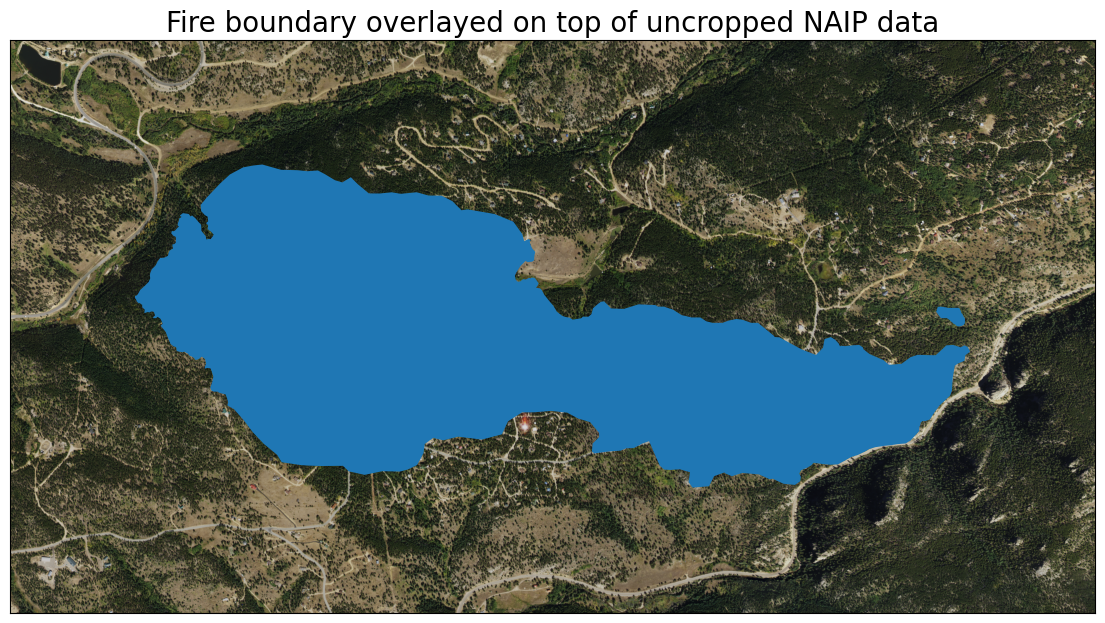

In [15]:
# Plot uncropped array
f, ax = plt.subplots()

ep.plot_rgb(naip_data.values,
            rgb=[0, 1, 2],
            ax=ax,
            title="Fire boundary overlayed on top of uncropped NAIP data",
            extent=naip_plot_extent)  # Use plotting extent from DatasetReader object

fire_bound_utmz13.plot(ax=ax)

plt.show()

Map of the un cropped NAIP RGB imagery overlayed with the Cold Springs Fire vector layer.

## Get Plotting Extent of Cropped Raster Layer
If you crop your data, the process of getting the the plotting_extent() is slightly different. The cropped layer does not have the same spatial attributes of the original dataset. In this case, you will have to use the metadata dictionary, returned from the crop function to create your plotting extent.

For a cropped array, the plotting_extent() function needs an additional parameter for the affine information, which can be accessed from the transform key in the metadata dictionary.

In [16]:
# Getting the crs of the raster data
naip_crs = es.crs_check(naip_path)

# Transforming the fire boundary to the NAIP data crs
fire_bound_utmz13 = fire_boundary.to_crs(naip_crs)

# Opening and clipping the NAIP data. The clip is applied before the data is opened, which 
# makes this faster then opening the data and clipping it after!
naip_data_clip = rxr.open_rasterio(naip_path, 
                                   masked=True).rio.clip(fire_bound_utmz13.geometry)

# Getting the new plotting extent
naip_clip_plot_extent = plotting_extent(naip_data_clip[0], naip_data_clip.rio.transform())

In [17]:
naip_clip_plot_extent

(457667.0, 461036.0, 4425146.0, 4426449.0)

## Plot Vector and Raster Data Overlays With Plotting Extent
Using the extent objects you created, you can now plot either uncropped or cropped arrays with the fire boundary using the extent parameter of plot functions that rely on matplotlib.

For example, to plot an RGB image, you can use plot_rgb()from earthpy (which uses matplotlib) and use the extent parameter to provide the appropriate plotting extent.

/opt/conda/lib/python3.11/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


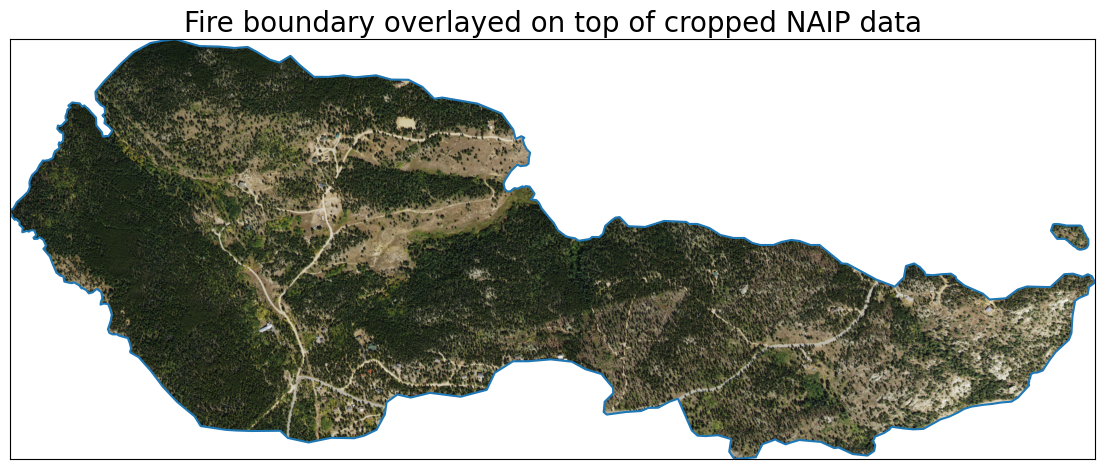

In [18]:
# Plot cropped data
f, ax = plt.subplots()

ep.plot_rgb(naip_data_clip,
            rgb=[0, 1, 2],
            ax=ax,
            title="Fire boundary overlayed on top of cropped NAIP data",
            extent=naip_clip_plot_extent)  # Use plotting extent from cropped array

fire_bound_utmz13.boundary.plot(ax=ax)

plt.show()

Map of the cropped NAIP RGB imagery overlayed with the Cold Springs Fire vector layer.

## Importance of Using Appropriate Plotting Extents
Below is an example of what happens if you do not define the plotting extent for a plot overlaying vector and raster data (array).

First, notice that both datasets plot fine individually.

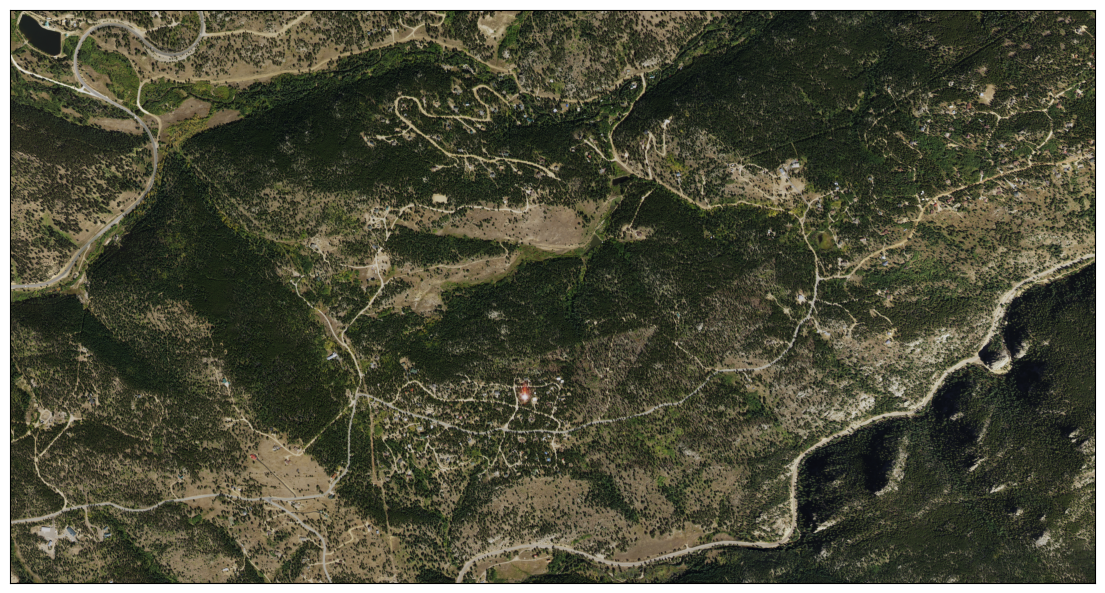

In [19]:
# Plot of uncropped array
f, ax = plt.subplots()

ep.plot_rgb(naip_data.values,
            rgb=[0, 1, 2],
            ax=ax)

plt.show()

Map of the NAIP RGB imagery of the Cold Springs fire area without the fire overlayed.

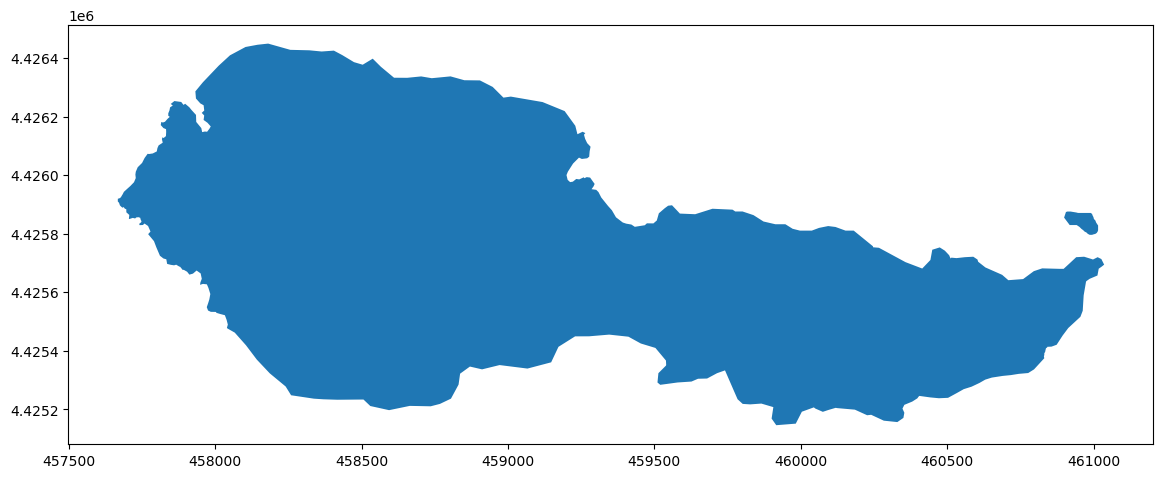

In [20]:
# Plot of fire boundary
f, ax = plt.subplots()

fire_bound_utmz13.plot(ax=ax)

plt.show()

Map of the Cold Springs fire area without imagery underneath.

Now notice that the plot does not render appropriately when you try to overlay the vector and raster data.

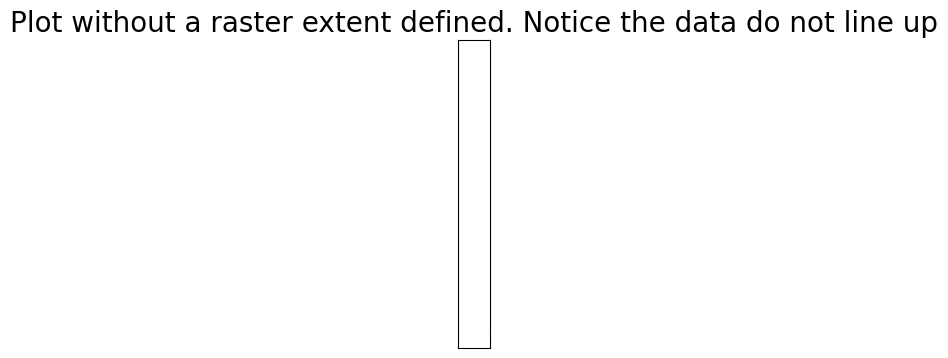

In [21]:
# Incorrect plot because plotting extent is not defined
f, ax = plt.subplots(figsize=(12, 4))

ep.plot_rgb(naip_data.values,
            rgb=[0, 1, 2],
            ax=ax,
           title="Plot without a raster extent defined. Notice the data do not line up")

fire_bound_utmz13.plot(ax=ax)

plt.show()

Map of the NAIP RGB imagery of the Cold Springs fire area with the fire overlayed without settting the plotting extent. No data is visible, it's just a long white box.

## Use the Appropriate Plotting Extent for Your Data
When you are plotting spatial data, it is important to consider which plotting extent you will need. You will need to create a unique plotting extent for each dataset in your project that is is either

- in a differennt CRS
- a different resolution and/or
- cropped differently

Even if the area that the plot covers is similar, if you use the wrong extent it can produce a plot that is skewed, stretched or in the incorrect geographic location

To demonstrate this, try to plot MODIS data using the NAIP extent that’s been cropped to the same area as the MODIS data, and see how the plot comes out. As the two satellites use differnet CRS’s, the data should be plotted in an illegible way.

In [22]:
# Open up and crop the MODIS data like you did with the NAIP data

modis_path = os.path.join('cold-springs-fire', 
                          'modis', 
                          'reflectance', 
                          '07_july_2016',
                          'crop', 
                          'MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b04_1.tif')

# Get crs of MODIS data
modis_crs = es.crs_check(modis_path)

# Change fire boundary crs to be the same as the MODIS data
fire_bound_WGS84 = fire_boundary.to_crs(modis_crs)

# Open and clip the MODIS data 
modis_data_clip = rxr.open_rasterio(modis_path, 
                                    masked=True).rio.clip(fire_bound_WGS84.geometry)

# Get the MODIS data's plotting extent
modis_clip_plot_extent = plotting_extent(modis_data_clip[0], 
                                         modis_data_clip.rio.transform())

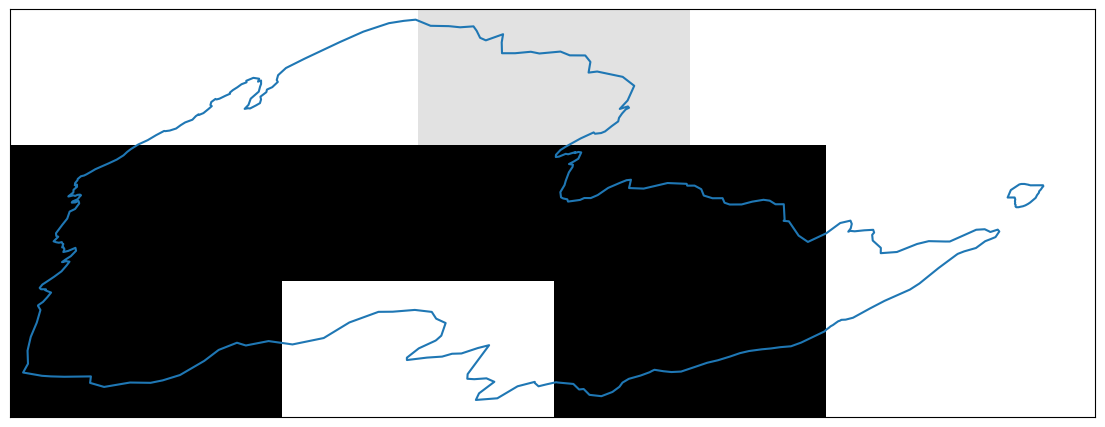

In [23]:
# Plot the MODIS data with the proper extent

# Plot cropped data
f, ax = plt.subplots()

ep.plot_bands(modis_data_clip,
              ax=ax,
              extent=modis_clip_plot_extent,
              cbar=False)

fire_bound_WGS84.boundary.plot(ax=ax)

plt.show()

Map of the cropped MODIS imagery overlayed with the Cold Springs Fire vector layer.

That skinny line below the plot code below is your actual plot! The plotting for NAIP data does not work for MODIS data as NAIP is:

- in a different corrdinate reference system and
- is at a different spatial resolution

Thus, you must create a unique plotting extent object for your MODIS data.

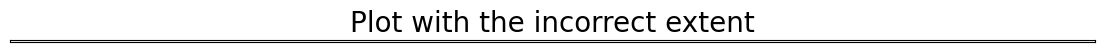

In [24]:
# Plotting MODIS with the NAIP extent

# Plot cropped data
f, ax = plt.subplots()

ep.plot_bands(modis_data_clip,
              ax=ax,
              extent=naip_clip_plot_extent,
              cbar=False,
              title="Plot with the incorrect extent")

fire_bound_WGS84.plot(ax=ax)

plt.show()



Map of the cropped MODIS RGB imagery overlayed with the Cold Springs Fire vector layer. The NAIP extent is used instead of the MODIS extent, so no data is visible, only a long black line.

Ref: https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/plotting-extents/